In [14]:
import os, re
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# - PATHS (edit if needed) -
ACTUALS_CSV = "/home/renga/Desktop/neoen_data/renga_work/data/measurements_neoen_morcenx_sep2025.csv"   # your actuals file (15-min, kWh)
PRICES_CSV  = "/home/renga/Desktop/neoen_data/renga_work/data/grid_penalty/combined_with_utc.csv"                    
FC_DIR      = Path("/home/renga/Desktop/neoen_data/renga_work/data/forecast_neoen_morcenx")

# - FORECAST filename pattern -
FC_TS_REGEX = re.compile(r"forecast_(\d{12})\.csv")   # captures YYYYMMDDHHMM

# - FORECAST columns -
FC_TARGET_COL = "horizon"   # tz-aware UTC
FC_DET_COL    = "deterministic"

# All available p_* columns you may have
FC_QUANT_COLS = [
    "p_05","p_10","p_15","p_20","p_25","p_30","p_35","p_40","p_45",
    "p_50","p_55","p_60","p_65","p_70","p_75","p_80","p_85","p_90","p_95"
]

# - PRICES columns -
PRICE_TIME_COL = "measure_date"   # UTC
PRICE_LONG_COL = "Long"           # over-production price (EUR/MWh)
PRICE_SHORT_COL= "Short"          # under-production price (EUR/MWh)

# - ACTUALS columns -
ACT_TIME_COL = "measure_date"     # UTC, 15-min
ACT_PROD_COL = "prod"             # kWh per 15-min

def normalize_p_selection(p_selection):
    """
    Accepts: 10 or [10,50,90] or 'p_10'/'p50'/'10' etc.
    Returns: list of valid p_* column names existing in FC_QUANT_COLS.
    """
    if p_selection is None:
        return []
    def to_col(x):
        s = str(x).lower().strip()
        if s.startswith("p_"): return s
        if s.startswith("p"):  return "p_" + s[1:].zfill(2)
        if s.isdigit():        return f"p_{int(s):02d}"
        try:
            return f"p_{int(float(s)):02d}"
        except Exception:
            return None
    vals = [p_selection] if not isinstance(p_selection, (list,tuple,set)) else list(p_selection)
    cols = []
    for v in vals:
        c = to_col(v)
        if c in FC_QUANT_COLS and c not in cols:
            cols.append(c)
    return cols

def run_time_to_file(run_ts_utc: pd.Timestamp) -> Path:
    ts_str = run_ts_utc.tz_convert("UTC").strftime("%Y%m%d%H%M")
    return FC_DIR / f"forecast_{ts_str}.csv"


In [15]:
# Actuals: 15-min kWh
actuals_15 = pd.read_csv(ACTUALS_CSV, parse_dates=[ACT_TIME_COL])
if actuals_15[ACT_TIME_COL].dtype.tz is None:
    actuals_15[ACT_TIME_COL] = actuals_15[ACT_TIME_COL].dt.tz_localize("UTC")
actuals_15 = actuals_15[[ACT_TIME_COL, ACT_PROD_COL]].sort_values(ACT_TIME_COL)

# Keep only exact 15-min stamps
mask_15 = (actuals_15[ACT_TIME_COL].dt.minute % 15 == 0) & (actuals_15[ACT_TIME_COL].dt.second == 0)
actuals_15 = actuals_15.loc[mask_15].reset_index(drop=True)

# Prices: 15-min for Long/Short; DA may be hourly 
prices = pd.read_csv(PRICES_CSV, parse_dates=[PRICE_TIME_COL])
if prices[PRICE_TIME_COL].dtype.tz is None:
    prices[PRICE_TIME_COL] = prices[PRICE_TIME_COL].dt.tz_localize("UTC")
prices = prices[[PRICE_TIME_COL, PRICE_LONG_COL, PRICE_SHORT_COL]].sort_values(PRICE_TIME_COL)


In [16]:
def load_forecast_run(run_ts_str: str, p_selection=None, include_det=True):
    """
    run_ts_str: 'YYYYMMDDHHMM' (UTC) e.g. '202510070515'
    p_selection: list/single of p-values to include, e.g., [10,50,90]
    """
    run_ts = pd.Timestamp(datetime.strptime(run_ts_str, "%Y%m%d%H%M"), tz="UTC")
    fc_path = run_time_to_file(run_ts)
    if not fc_path.exists():
        raise FileNotFoundError(f"Forecast file not found: {fc_path}")

    usecols = [FC_TARGET_COL] + ( [FC_DET_COL] if include_det else [] ) + normalize_p_selection(p_selection)
    if FC_TARGET_COL not in usecols:
        usecols.insert(0, FC_TARGET_COL)

    fc = pd.read_csv(fc_path, parse_dates=[FC_TARGET_COL], usecols=usecols)
    if fc[FC_TARGET_COL].dtype.tz is None:
        fc[FC_TARGET_COL] = fc[FC_TARGET_COL].dt.tz_localize("UTC")

    # Merge with actuals (target time ↔ measure_date) and prices on time
    merged = (fc
              .merge(actuals_15, left_on=FC_TARGET_COL, right_on=ACT_TIME_COL, how="inner")
              .merge(prices, left_on=FC_TARGET_COL, right_on=PRICE_TIME_COL, how="left")
             )

    # Clean columns
    merged = merged.rename(columns={FC_TARGET_COL: "target_time"})
    merged = merged.drop(columns=[ACT_TIME_COL, PRICE_TIME_COL], errors="ignore")

    # Lead hours for info
    merged["run_time"] = run_ts
    merged["lead_hours"] = (merged["target_time"] - merged["run_time"]).dt.total_seconds() / 3600.0

    return merged, run_ts, fc_path


In [17]:
def compute_penalties(df_run: pd.DataFrame, series_cols: list):
    """
    For each forecast series in `series_cols`, compute:
      delta_MWh = (actual_kWh - forecast_kWh)/1000
      applied_price = Long if delta>0 (overprod), else Short (underprod)
      penalty_eur = delta_MWh * applied_price   (signed: negative values are 'negative penalty'/benefit)
    Returns (long_table, summary_table)
    """
    out_frames = []
    for col in series_cols:
        if col not in df_run.columns:
            continue
        tmp = df_run[["run_time","target_time","lead_hours", ACT_PROD_COL, PRICE_LONG_COL, PRICE_SHORT_COL, col]].copy()
        tmp = tmp.rename(columns={col: "forecast_kWh"})
        # convert kWh -> MWh over the 15-min interval
        tmp["actual_MWh"]   = tmp[ACT_PROD_COL] / (1000.0*4)  # 15-min kWh to MWh
        tmp["forecast_MWh"] = tmp["forecast_kWh"] / (1000.0*4)
        tmp["delta_MWh"]    = tmp["actual_MWh"] - tmp["forecast_MWh"]  # >0 => overproduction

        # choose price
        tmp["applied_price_EUR_per_MWh"] = np.where(tmp["delta_MWh"] > 0, tmp[PRICE_LONG_COL], tmp[PRICE_SHORT_COL])

        # penalty (signed); a negative price will naturally create a 'negative penalty' (benefit)
        tmp["penalty_EUR"] = tmp["delta_MWh"] * tmp["applied_price_EUR_per_MWh"]
        tmp["forecast_type"] = col.replace("p_", "p") if col != FC_DET_COL else "deterministic"

        out_frames.append(tmp[[
            "run_time","target_time","lead_hours","forecast_type",
            "forecast_kWh", ACT_PROD_COL, "delta_MWh",
            "applied_price_EUR_per_MWh","penalty_EUR"
        ]])

    if not out_frames:
        return pd.DataFrame(), pd.DataFrame()

    long_tbl = pd.concat(out_frames, ignore_index=True).sort_values(["forecast_type","target_time"])
    # summary totals per forecast type for the whole run
    summary = (long_tbl
               .groupby("forecast_type", as_index=False)
               .agg(
                   n_15min=("penalty_EUR","size"),
                   total_penalty_EUR=("penalty_EUR","sum"),
                   avg_penalty_EUR=("penalty_EUR","mean"),
                   p95_penalty_EUR=("penalty_EUR", lambda s: np.nanpercentile(s, 95)),
                   p05_penalty_EUR=("penalty_EUR", lambda s: np.nanpercentile(s, 5)),
               )
               .sort_values("total_penalty_EUR")
              )
    return long_tbl, summary


In [18]:
# Forecast run time to evaluate
RUN_TIME_STR = "202509101100"          # e.g. 'YYYYMMDDHHMM' (UTC)


In [19]:
GRID_STATE = Path("/home/renga/Desktop/neoen_data/renga_work/outputs_same_tod/predicted_grid_state_dow.csv")

# run-time–specific revenue + penalty ledger

    - Pick one forecast run (e.g., forecast_YYYYMMDDHHMM.csv)

    - For the next 48h 15-min targets, compute per block:

    - Actual (kWh → MWh)

    - Deterministic & chosen p_xx forecasts

    - Δ = actual − forecast (MWh)

    - Revenue = actual_MWh × DA price (€/MWh) (using the hour’s DA price)

    - Penalty (Long for overproduction; Short for underproduction)

    - Net revenue = Revenue + Penalty

In [20]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import re

# ===================== PATHS (edit if needed) =====================
ACTUALS_CSV = "/home/renga/Desktop/neoen_data/renga_work/data/measurements_neoen_morcenx_sep2025.csv"      # actuals (kW @ 15-min)
PRICES_CSV  = "/home/renga/Desktop/neoen_data/renga_work/data/grid_penalty/combined_with_utc.csv"             # has measure_date, da_price, Long, Short
FC_DIR      = Path("/home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx")


# Actuals
ACT_TIME_COL = "measure_date"    # UTC tz-aware
ACT_PROD_COL = "prod"            # kW over the 15-min block

# Prices
PRICE_TIME_COL   = "measure_date"  # UTC tz-aware
PRICE_DA_COL     = "da_price"      # EUR/MWh (hourly or 15-min; we'll FFILL to quarters)
PRICE_LONG_COL   = "Long"          # EUR/MWh for overproduction (15-min)
PRICE_SHORT_COL  = "Short"         # EUR/MWh for underproduction (15-min)

# Forecasts 
FC_TARGET_COL = "horizon"          # tz-aware UTC timestamps of the target quarters
FC_DET_COL    = "deterministic"
FC_CLEAR_COL  = "clear_sky"
FC_TS_REGEX   = re.compile(r"forecast_(\d{12})\.csv")   # from filename
FC_QUANT_COLS = [
    "p_05","p_10","p_15","p_20","p_25","p_30","p_35","p_40","p_45",
    "p_50","p_55","p_60","p_65","p_70","p_75","p_80","p_85","p_90","p_95"
 ]

# Units: kW @ 15-min → MWh
KW_TO_MWH_QUARTER = 1.0 / (1000.0 * 4.0)  # 0.00025

def normalize_p_selection(p_selection):
    """Accept 10, 'p_10', 'p10', [10,50,90], etc. Return valid p_* column names present in FC_QUANT_COLS."""
    if p_selection is None:
        return []
    def to_col(x):
        s = str(x).strip().lower()
        if s.startswith("p_"): return s
        if s.startswith("p"):  return "p_" + s[1:].zfill(2)
        if s.replace(".","",1).isdigit(): return f"p_{int(float(s)):02d}"
        return None
    vals = [p_selection] if not isinstance(p_selection, (list,tuple,set)) else list(p_selection)
    out = []
    for v in vals:
        c = to_col(v)
        if c in FC_QUANT_COLS and c not in out:
            out.append(c)
    return out

def run_time_to_path(run_ts_utc: pd.Timestamp) -> Path:
    return FC_DIR / f"forecast_{run_ts_utc.tz_convert('UTC').strftime('%Y%m%d%H%M')}.csv"

def load_inputs():
    # Actuals (kW @ 15-min)
    a = pd.read_csv(ACTUALS_CSV, parse_dates=[ACT_TIME_COL])
    if a[ACT_TIME_COL].dtype.tz is None:
        a[ACT_TIME_COL] = a[ACT_TIME_COL].dt.tz_localize("UTC")
    # keep exact quarter-hour stamps
    mask_15 = (a[ACT_TIME_COL].dt.minute % 15 == 0) & (a[ACT_TIME_COL].dt.second == 0)
    a = a.loc[mask_15, [ACT_TIME_COL, ACT_PROD_COL]].sort_values(ACT_TIME_COL).reset_index(drop=True)

    # Prices
    p = pd.read_csv(PRICES_CSV, parse_dates=[PRICE_TIME_COL])
    if p[PRICE_TIME_COL].dtype.tz is None:
        p[PRICE_TIME_COL] = p[PRICE_TIME_COL].dt.tz_localize("UTC")
    p = p[[PRICE_TIME_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]].sort_values(PRICE_TIME_COL)

    # Numeric sanitize
    for c in [PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]:
        if c in p.columns:
            p[c] = pd.to_numeric(p[c], errors="coerce")

    # Ensure a 15-min DA series by ffill (safe for DA hourly → all quarters)
    p = p.set_index(PRICE_TIME_COL).sort_index()
    if PRICE_DA_COL in p.columns:
        p[PRICE_DA_COL] = p[PRICE_DA_COL].ffill()
    p = p.reset_index()

    return a, p

def load_forecast_run(run_time_str: str, p_selection=None, include_det=True, include_clear=False):
    """
    run_time_str: 'YYYYMMDDHHMM' (UTC) of the forecast file, e.g. '202507071515'
    Returns: fc DataFrame with target horizon + selected columns, plus run_time & lead_hours
    """
    run_ts = pd.Timestamp(datetime.strptime(run_time_str, "%Y%m%d%H%M"), tz="UTC")
    fpath = run_time_to_path(run_ts)
    if not fpath.exists():
        raise FileNotFoundError(f"Missing forecast file: {fpath}")

    cols = [FC_TARGET_COL]
    if include_det:   cols.append(FC_DET_COL)
    if include_clear: cols.append(FC_CLEAR_COL)
    cols += normalize_p_selection(p_selection)

    # Read forecast file
    fc = pd.read_csv(fpath, parse_dates=[FC_TARGET_COL], usecols=cols)
    if fc[FC_TARGET_COL].dtype.tz is None:
        fc[FC_TARGET_COL] = fc[FC_TARGET_COL].dt.tz_localize("UTC")

    fc = fc.sort_values(FC_TARGET_COL).reset_index(drop=True)
    fc["run_time"] = run_ts
    fc["lead_hours"] = (fc[FC_TARGET_COL] - run_ts).dt.total_seconds() / 3600.0
    return fc, run_ts, fpath

In [ ]:
def build_run_ledger(run_time_str: str, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    """
    For a single forecast issuance:
      - joins forecast horizons with actuals and prices,
      - converts kW (15-min) -> MWh correctly,_______
     15min1 -computes Revenue (actual_MWh * DA €/MWh),
      - computes Penalty (delta_MWh * Long/Short €/MWh),
      - optionally adds strategy columns (e.g., str_1) based on directional signals,
      - returns a long-form ledger + per-forecast-type summary.

    strategy_spec: optional dict with keys:
        column_name     -> name for the new strategy column (e.g., "str_1")
        lower           -> lower quantile column name (e.g., "p_30")
        upper           -> upper quantile column name (e.g., "p_70")
        grid_state_path -> path to CSV containing "target_ts" and "pred_state" (1/0/-1)
    """
    actuals, prices = load_inputs()
    fc, run_ts, fpath = load_forecast_run(run_time_str, p_selection, include_det, include_clear)
    
    # Merge on target horizon time
    merged = (fc
              .merge(actuals, left_on=FC_TARGET_COL, right_on=ACT_TIME_COL, how="inner")
              .merge(prices, left_on=FC_TARGET_COL, right_on=PRICE_TIME_COL, how="left")
             )
    
    # Columns to convert/sanitize (numerics)
    selected_fc_cols = []
    if include_det and FC_DET_COL in merged.columns: selected_fc_cols.append(FC_DET_COL)
    if include_clear and FC_CLEAR_COL in merged.columns: selected_fc_cols.append(FC_CLEAR_COL)
    selected_fc_cols += [c for c in normalize_p_selection(p_selection) if c in merged.columns]
    
    for c in [ACT_PROD_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols:
        if c in merged.columns:
            merged[c] = pd.to_numeric(merged[c], errors="coerce")
    
    # Optional strategy column based on directional signals
    if strategy_spec is not None:
        column_name = strategy_spec.get("column_name", "str_1")
        lower_col = strategy_spec.get("lower")
        upper_col = strategy_spec.get("upper")
        grid_state_path = strategy_spec.get("grid_state_path")
        if not all([column_name, lower_col, upper_col, grid_state_path]):
            raise ValueError("strategy_spec must include column_name, lower, upper, and grid_state_path")
        for col in (lower_col, upper_col):
            if col not in merged.columns:
                raise KeyError(f"Required quantile column '{col}' missing from merged forecast data.")
        grid_state = pd.read_csv(grid_state_path, parse_dates=["target_ts"])
        if grid_state["target_ts"].dtype.tz is None:
            grid_state["target_ts"] = grid_state["target_ts"].dt.tz_localize("UTC")
        grid_state = (grid_state
                       .rename(columns={"target_ts": "target_time"})
                       .drop_duplicates(subset=["target_time"], keep="last")
                       [["target_time", "pred_state"]])
        
        # Ensure merged has 'target_time' for the join
        if "target_time" not in merged.columns:
            merged["target_time"] = merged[FC_TARGET_COL]
        
        merged = merged.merge(grid_state, on="target_time", how="left")
        if merged["pred_state"].isna().all():
            raise ValueError("pred_state is missing for all rows; check grid_state_path or timestamp alignment.")
        merged[column_name] = np.where(
            merged["pred_state"] < 0, merged[lower_col],
            np.where(
                merged["pred_state"] > 0, merged[upper_col], 0.5 * (merged[lower_col] + merged[upper_col])
            )
        )
        merged[column_name] = pd.to_numeric(merged[column_name], errors="coerce")
        selected_fc_cols.append(column_name)
    
    # kW @ 15-min -> MWh
    merged["actual_MWh"] = merged[ACT_PROD_COL] * KW_TO_MWH_QUARTER
    
    # Revenue from actuals at DA price
    merged["revenue_EUR"] = merged["actual_MWh"] * merged[PRICE_DA_COL]
    
    # Long-form over forecast series
    long = (merged[[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh",
                    ACT_PROD_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols]
            .melt(id_vars=[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh",
                           ACT_PROD_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL],
                  var_name="forecast_col", value_name="forecast_kW")
            .rename(columns={FC_TARGET_COL: "target_time"})
           )
    
    # Forecast energy in MWh
    long["forecast_MWh"] = long["forecast_kW"] * KW_TO_MWH_QUARTER
    long["forecast_type"] = (long["forecast_col"]
                             .str.replace("p_", "p", regex=False)
                             .mask(long["forecast_col"].eq(FC_DET_COL), "deterministic")
                             .mask(long["forecast_col"].eq(FC_CLEAR_COL), "clear_sky"))
    
    # Delta & penalty rule
    long["delta_MWh"] = long["actual_MWh"] - long["forecast_MWh"]  # >0 overprod ⇒ Long
    long["applied_price_EUR_per_MWh"] = np.where(long["delta_MWh"] > 0,
                                                 long[PRICE_LONG_COL],
                                                 long[PRICE_SHORT_COL])
    long["penalty_EUR"] = long["delta_MWh"] * long["applied_price_EUR_per_MWh"]
    
    # Net revenue
    long = long.merge(merged[[FC_TARGET_COL, "revenue_EUR"]].rename(columns={FC_TARGET_COL:"target_time"}),
                      on="target_time", how="left")
    long["net_revenue_EUR"] = long["revenue_EUR"] + long["penalty_EUR"]
    
    # Order columns
    long = long[["run_time","target_time","lead_hours","forecast_type",
                 "actual_MWh","forecast_MWh","delta_MWh",
                 PRICE_DA_COL,"revenue_EUR",
                 "applied_price_EUR_per_MWh","penalty_EUR","net_revenue_EUR"]]
    long = long.sort_values(["forecast_type","target_time"]).reset_index(drop=True)
    
    # Summary per forecast type
    summary = (long.groupby("forecast_type", as_index=False)
                    .agg(
                        n_15min=("net_revenue_EUR","size"),
                        total_revenue_EUR=("revenue_EUR","sum"),
                        total_penalty_EUR=("penalty_EUR","sum"),
                        total_net_EUR=("net_revenue_EUR","sum"),
                        mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                        rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
                    )
                    .sort_values("total_net_EUR", ascending=False)
              )
    return long, summary, fpath, run_ts

In [22]:
RUN_TIME_STR = "202509111100"     # <-- choose any forecast file time (UTC) you want
P_SELECTION  = [10,20,30,40, 50,60, 70,80,90]       # quantiles to include; set [] for none
INCLUDE_DET  = True
INCLUDE_CLEAR= False
STRATEGY_SPEC = {
    "column_name": "str_1",
    "lower": "p_40",
    "upper": "p_70",
    "grid_state_path": GRID_STATE
}

ledger, summary, fpath, run_ts = build_run_ledger(
    RUN_TIME_STR, p_selection=P_SELECTION, include_det=INCLUDE_DET, include_clear=INCLUDE_CLEAR,
    strategy_spec=STRATEGY_SPEC
)

print(f"Using {fpath.name}   (run_time={run_ts})")
display(summary)
display(ledger)

Using forecast_202509111100.csv   (run_time=2025-09-11 11:00:00+00:00)


,forecast_type,n_15min,total_revenue_EUR,total_penalty_EUR,total_net_EUR,mae_MWh,rmse_MWh
9,p90,192,626.58707,876.846723,1503.268385,1.325364,1.589801
10,str_1,192,626.58707,697.079138,1323.500799,0.792937,1.020061
7,p70,192,626.58707,284.463766,910.885427,0.796346,1.013509
6,p60,192,626.58707,257.469177,883.890838,0.668188,0.883450
8,p80,192,626.58707,203.554078,829.975739,1.007430,1.236467
0,deterministic,192,626.58707,146.882245,773.303907,0.616590,0.832133
5,p50,192,626.58707,66.938924,693.360585,0.584174,0.815399
4,p40,192,626.58707,-95.512649,530.909012,0.558005,0.801772
3,p30,192,626.58707,-337.054474,289.367187,0.568767,0.833611
2,p20,192,626.58707,-648.420548,-21.998887,0.601787,0.881102


,run_time,target_time,lead_hours,forecast_type,actual_MWh,forecast_MWh,delta_MWh,da_price,revenue_EUR,applied_price_EUR_per_MWh,penalty_EUR,net_revenue_EUR
0,2025-09-11 11:00:00+00:00,2025-09-11 11:15:00+00:00,0.25,deterministic,0.000000,1.070470,-1.070470,-0.01,-0.000000,-4.79,5.127551,5.127551
1,2025-09-11 11:00:00+00:00,2025-09-11 11:30:00+00:00,0.50,deterministic,0.000000,1.511767,-1.511767,-0.01,-0.000000,-4.79,7.241362,7.241362
2,2025-09-11 11:00:00+00:00,2025-09-11 11:45:00+00:00,0.75,deterministic,0.000000,1.807968,-1.807968,-0.01,-0.000000,-99.69,180.236292,180.236292
3,2025-09-11 11:00:00+00:00,2025-09-11 12:00:00+00:00,1.00,deterministic,0.000000,2.323952,-2.323952,-0.01,-0.000000,-70.92,164.814683,164.814683
4,2025-09-11 11:00:00+00:00,2025-09-11 12:15:00+00:00,1.25,deterministic,0.000000,2.285061,-2.285061,-0.01,-0.000000,-79.49,181.639535,181.639535
...,...,...,...,...,...,...,...,...,...,...,...,...
2107,2025-09-11 11:00:00+00:00,2025-09-13 10:00:00+00:00,47.00,str_1,0.715017,1.900235,-1.185219,0.00,0.000000,-44.07,52.232581,52.232581
2108,2025-09-11 11:00:00+00:00,2025-09-13 10:15:00+00:00,47.25,str_1,0.537106,1.896488,-1.359382,0.00,0.000000,37.21,-50.582599,-50.582599
2109,2025-09-11 11:00:00+00:00,2025-09-13 10:30:00+00:00,47.50,str_1,0.808935,1.920504,-1.111569,0.00,0.000000,37.28,-41.439298,-41.439298
2110,2025-09-11 11:00:00+00:00,2025-09-13 10:45:00+00:00,47.75,str_1,1.242532,1.966295,-0.723764,0.00,0.000000,104.53,-75.655028,-75.655028


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- EDIT THESE ----
START_TS = pd.to_datetime("2025-09-12 00:00:00+00:00")
END_TS   = pd.to_datetime("2025-09-12 23:00:00+00:00")

deterministic total_net_EUR = 181.52 €, str_1 total_net_EUR = 544.90 €, pct vs deterministic = 200.19%


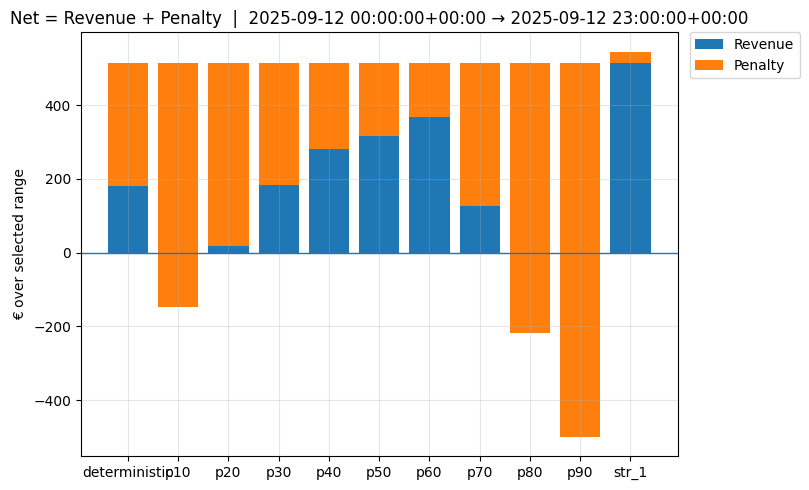

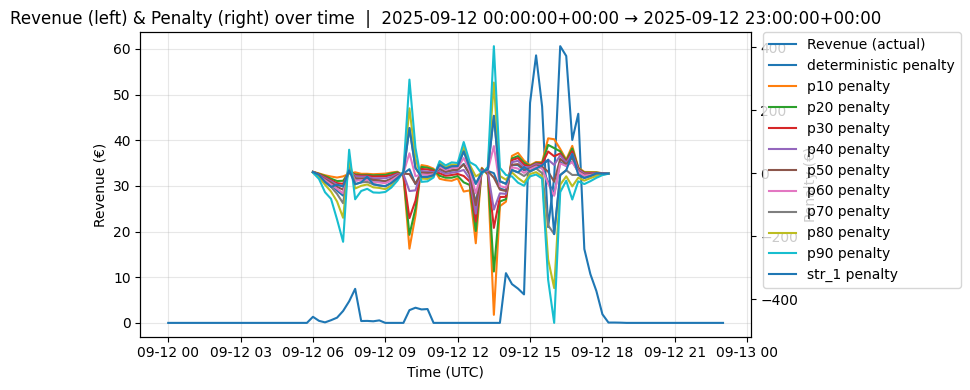

In [24]:

SELECTED_TYPES = ["deterministic", "p10", "p20","p30", "p40","p50","p60", "p70","p80","p90", "str_1"]   # choose any from ledger['forecast_type'].unique()

# 1) Filter
mask = (ledger["target_time"] >= START_TS) & (ledger["target_time"] <= END_TS) & (ledger["forecast_type"].isin(SELECTED_TYPES))
df = ledger.loc[mask].copy().sort_values(["forecast_type","target_time"])
if df.empty:
    raise ValueError("No data in the selected time range or series. Adjust START_TS / END_TS / SELECTED_TYPES.")

# 2) Aggregated stacked bars: Revenue + Penalty per forecast type
agg = (df.groupby("forecast_type", as_index=False)
         .agg(total_revenue_EUR=("revenue_EUR","sum"),
              total_penalty_EUR=("penalty_EUR","sum"),
              total_net_EUR=("net_revenue_EUR","sum")))

# compute percent vs deterministic
det_net = np.nan
if "deterministic" in agg["forecast_type"].values:
    det_net = float(agg.loc[agg["forecast_type"]=="deterministic","total_net_EUR"].iloc[0])

agg["pct_vs_det"] = np.nan
if np.isfinite(det_net) and det_net != 0:
    agg["pct_vs_det"] = (agg["total_net_EUR"] - det_net) / np.abs(det_net) * 100.0

# print a compact summary for str_1 vs deterministic if both present
if ("str_1" in agg["forecast_type"].values) and ("deterministic" in agg["forecast_type"].values):
    str_net = float(agg.loc[agg["forecast_type"]=="str_1","total_net_EUR"].iloc[0])
    pct = float(agg.loc[agg["forecast_type"]=="str_1","pct_vs_det"].iloc[0])
    print(f"deterministic total_net_EUR = {det_net:,.2f} €, str_1 total_net_EUR = {str_net:,.2f} €, pct vs deterministic = {pct:.2f}%")

fig, ax = plt.subplots(figsize=(10,5))
x = np.arange(len(agg))
ax.bar(x, agg["total_revenue_EUR"], label="Revenue")
ax.bar(x, agg["total_penalty_EUR"], bottom=agg["total_revenue_EUR"], label="Penalty")
ax.set_xticks(x)
ax.set_xticklabels(agg["forecast_type"])
ax.set_ylabel("€ over selected range")
ax.set_title(f"Net = Revenue + Penalty  |  {START_TS} → {END_TS}")
ax.axhline(0, lw=1)
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

# 3) Time series panel: Revenue (left y) & penalties (right y)
fig, ax1 = plt.subplots(figsize=(11,4))

rev_series = (df[["target_time","revenue_EUR"]]
              .drop_duplicates(subset=["target_time"])
              .sort_values("target_time"))
ax1.plot(rev_series["target_time"], rev_series["revenue_EUR"], label="Revenue (actual)", linewidth=1.5)
ax1.set_xlabel("Time (UTC)")
ax1.set_ylabel("Revenue (€)")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
for ft in SELECTED_TYPES:
    s = df.loc[df["forecast_type"]==ft, ["target_time","penalty_EUR"]].sort_values("target_time")
    ax2.plot(s["target_time"], s["penalty_EUR"], label=f"{ft} penalty")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax2.legend(lines1+lines2, labels1+labels2, loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)
ax2.set_ylabel("Penalty (€)")
plt.title(f"Revenue (left) & Penalty (right) over time  |  {START_TS} → {END_TS}")
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()


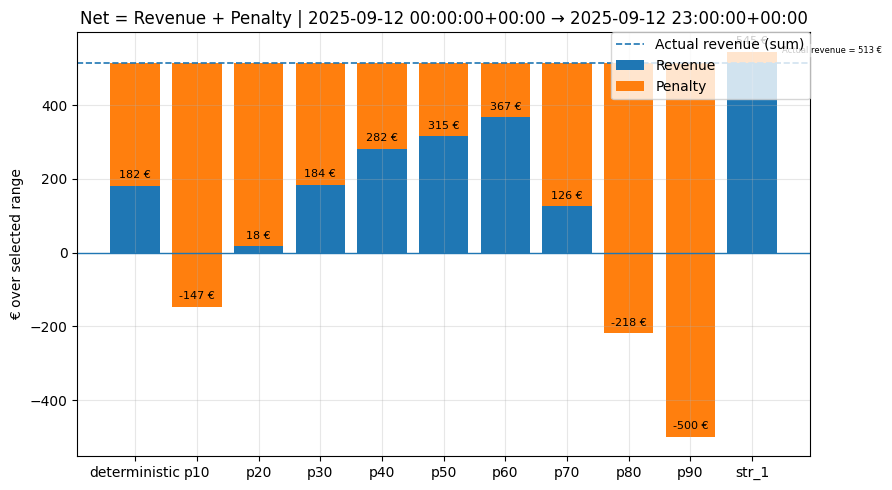

In [25]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10,5))

x = np.arange(len(agg))
rev = agg["total_revenue_EUR"].to_numpy()
pen = agg["total_penalty_EUR"].to_numpy()
net = rev + pen

# Stacked bars
bars_rev = ax.bar(x, rev, label="Revenue")
bars_pen = ax.bar(x, pen, bottom=rev, label="Penalty")

# X labels
ax.set_xticks(x)
ax.set_xticklabels(agg["forecast_type"])

# ---- Guideline at total Actual Revenue (same across forecast types for a given time window) ----
rev_sum = float(np.nanmean(rev)) if len(rev) else np.nan
if np.isfinite(rev_sum):
    ax.axhline(rev_sum, linestyle="--", linewidth=1.2, label="Actual revenue (sum)")

# Label the guideline (place it near the right edge)
if np.isfinite(rev_sum) and len(x):
    ax.annotate(
        f"Actual revenue = {rev_sum:,.0f} €",
        xy=(x[-1] + 0.35, rev_sum),  # slightly to the right of last bar
        xycoords=("data", "data"),
        textcoords="offset points",
        xytext=(6, 6),
        ha="left",
        va="bottom",
        fontsize=6,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.85),
        clip_on=False
    )

# ---- Net revenue labels on top of each stacked bar ----
for xi, yi in zip(x, net):
    ax.annotate(
        f"{yi:,.0f} €",
        xy=(xi, yi),
        xycoords="data",
        textcoords="offset points",
        xytext=(0, 4),       # little offset above the stack
        ha="center",
        va="bottom",
        fontsize=8
    )

# Cosmetics
ax.set_ylabel("€ over selected range")
ax.set_title(f"Net = Revenue + Penalty | {START_TS} → {END_TS}")
ax.axhline(0, linewidth=1)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.legend(loc="upper right", bbox_to_anchor=(1, 1), borderaxespad=0.)
ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

deterministic total_net_EUR = 181.52 €, str_1 total_net_EUR = 544.90 €, Percentage Increase = 200.19%


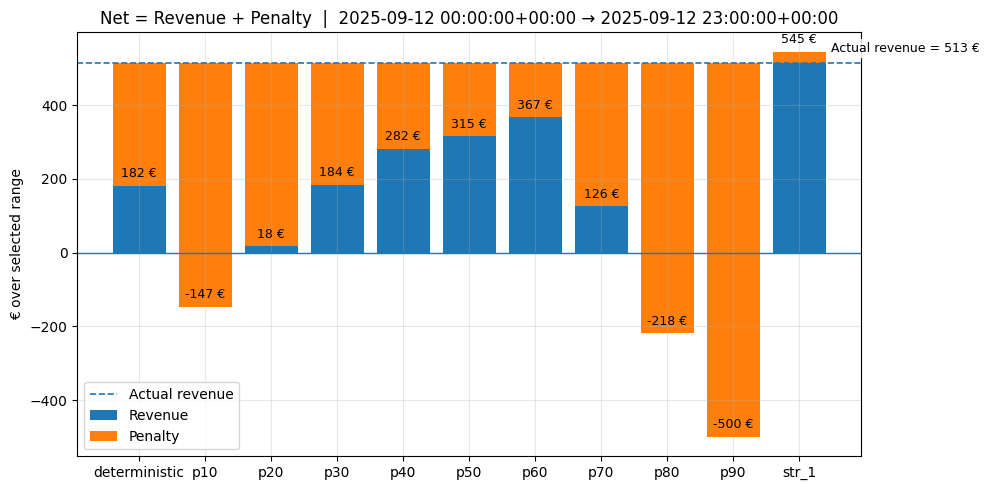

In [26]:
import matplotlib.ticker as mtick

# compute percent vs deterministic
det_net = np.nan
if "deterministic" in agg["forecast_type"].values:
    det_net = float(agg.loc[agg["forecast_type"]=="deterministic","total_net_EUR"].iloc[0])

agg["pct_vs_det"] = np.nan
if np.isfinite(det_net) and det_net != 0:
    agg["pct_vs_det"] = (agg["total_net_EUR"] - det_net) / np.abs(det_net) * 100.0

# print a compact summary for str_1 vs deterministic if both present
if ("str_1" in agg["forecast_type"].values) and ("deterministic" in agg["forecast_type"].values):
    str_net = float(agg.loc[agg["forecast_type"]=="str_1","total_net_EUR"].iloc[0])
    pct = float(agg.loc[agg["forecast_type"]=="str_1","pct_vs_det"].iloc[0])
    print(f"deterministic total_net_EUR = {det_net:,.2f} €, str_1 total_net_EUR = {str_net:,.2f} €, Percentage Increase = {pct:.2f}%")


fig, ax = plt.subplots(figsize=(10,5))

x = np.arange(len(agg))
rev = agg["total_revenue_EUR"].to_numpy()
pen = agg["total_penalty_EUR"].to_numpy()
net = rev + pen

# Stacked bars
bars_rev = ax.bar(x, rev, label="Revenue")
bars_pen = ax.bar(x, pen, bottom=rev, label="Penalty")

# X labels
ax.set_xticks(x)
ax.set_xticklabels(agg["forecast_type"])

# ---- Guideline at total Actual Revenue (same across forecast types for a given time window) ----
rev_sum = float(np.nanmean(rev)) if len(rev) else np.nan
if np.isfinite(rev_sum):
    ax.axhline(rev_sum, linestyle="--", linewidth=1.2, label="Actual revenue")

# Label the guideline (place it near the right edge)
if np.isfinite(rev_sum) and len(x):
    ax.annotate(
        f"Actual revenue = {rev_sum:,.0f} €",
        xy=(x[-1] + 0.35, rev_sum),  # slightly to the right of last bar
        xycoords=("data", "data"),
        textcoords="offset points",
        xytext=(6, 6),
        ha="left",
        va="bottom",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.85),
        clip_on=False
    )

# ---- Net revenue labels on top of each stacked bar ----
for xi, yi in zip(x, net):
    ax.annotate(
        f"{yi:,.0f} €",
        xy=(xi, yi),
        xycoords="data",
        textcoords="offset points",
        xytext=(0, 4),       # little offset above the stack
        ha="center",
        va="bottom",
        fontsize=9
    )

# Cosmetics
ax.set_ylabel("€ over selected range")
ax.set_title(f"Net = Revenue + Penalty  |  {START_TS} → {END_TS}")
ax.axhline(0, linewidth=1)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Bidding Strategy